# Методы, основанные на линейном приближении Q-функции

Рассмотрим методы обучения агента, основанные на приближении значений Q-функции с помощью **линейной параметрической модели**.
В качестве управляющего алгоритма будем использовать n-шаговый метод SARSA (но можно использовать и любой другой метод). 
Для работы модели требуется из пар $(s,a)$ сформировать вектора признаков этой пары $f(s,a)$.
Тогда линейная параметрическая модель формирует значения Q-функции $\widehat{q}(s,a,\theta)$ в виде скалярного произведение вектора признаков $f(s,a)$ на вектор параметров $\theta$:

$$\widehat{q}(s,a,\theta) = \langle f(s,a), \theta \rangle = f(s,a)^T \theta.$$

Необходимо написать новый класс для агента, реализующий вычисление значений Q-функции по линейной параметрической модели и способ обновления параметров по методу градиентного спуска.

Вместо Q-таблицы класс агента будет хранить внутри себя вектор параметров. Соответствующим образом надо изменить код для обновления параметров и выбора максимального по ценности действия.

Кроме того, для обеспечения модульной структуры кода и чтобы сохранить сигнатуру методов агента (то есть количество и тип аргументов), агент будет принимать класс `featureCoder`, в котором будет прописано, как по паре состояние-действие получить признаки. Как минимум, этот класс должен содержать поле `featureCoder.num_of_features` с числом признаков в векторе признаков. А также метод

    `get_features()` для построения вектора признаков по паре состояние-действие.
    
Для каждой конкретной задачи нужно прописывать свой класс `featureCoder`.

In [3]:
import numpy as np

class LinearModelAgent:
    def __init__(self, env, featureCoder, eps = 0.1, alpha = 0.1):
        self.eps = eps               
        self.alpha = alpha           # параметр шага обучения
        # агент работает для сред с одним набором действий во всех состояниях
        self.actions = np.arange(env.action_space.n)
        
        self.fCoder = featureCoder
        # параметры модели
        self.theta = np.zeros(featureCoder.num_of_features)

    # вычисление Q(s,a)
    def get_Q(self, state, action):
        feats = self.fCoder.get_features(state, action)
        return self.theta @ feats
        
    # обновление параметров шагом градиентного спуска
    def update(self, state, action, target):
        feats = self.fCoder.get_features(state, action)
        q_s_a = self.theta @ feats
        
        delta = target - q_s_a
        self.theta += self.alpha * delta * feats

    # жадное действие в состоянии state
    def best_action(self, state):
        qvals=[]
        for action in self.actions:
            qvals.append(self.get_Q(state,action))
        return np.argmax(qvals)
    
    def get_action(self, state):
        if np.random.rand() < self.eps:
            return np.random.choice(self.actions)
        else:
            return self.best_action(state)

    def play(self, env, n_episodes):
        for _ in tqdm(range(n_episodes)):
            state, _ = env.reset()
            while True:
                # выбираем лучшие действия
                action = self.best_action(state)
                state, reward, terminated, truncated, _ = env.step(action)
                if terminated or truncated:
                    break

Управляющие алгоритмы можно использовать без изменений. Скопируем, например, n-шаговый метод SARSA.

In [1]:
from tqdm import tqdm

# алгоритм обучения, возврат: массив доходов 
def SARSA_Nstep_control(env, agent, n_episodes=10000, gamma = 1.0, 
                      eps_start=0.5, eps_decay = 1.0, eps_min = 0.01,
                      alpha_start=0.2, alpha_decay = 1.0, alpha_min = 0.01, nstep=10):
    n = nstep
    agent.eps = eps_start
    agent.alpha = alpha_start
    
    for i in tqdm(range(n_episodes)):
        state, _ = env.reset()
        action = agent.get_action(state)
        T = float('inf')
        t = 0
        states = [state]
        actions = [action]
        rewards = [0.0]                
        while True:
            if t < T:
                state, reward, terminated, truncated, _= env.step(action)
                states.append(state)
                rewards.append(reward)
                
                if terminated or truncated:
                    T = t+1
                else:
                    next_action = agent.get_action(state)
                    actions.append(next_action)

            tau = t - n + 1
            if tau >= 0:
                upd_goal = 0
                # сумма от tau+1 до min(tau+n, T)
                for i in range(tau+1, min(tau+n, T)+1):
                    upd_goal += gamma ** (i-tau-1) * rewards[i]
                if tau+n < T:
                    upd_goal += gamma**n * agent.get_Q(states[tau+n],actions[tau+n])
                agent.update(states[tau], actions[tau], upd_goal)
            
            if tau == T - 1:
                break
            else:
                t += 1
                action = next_action
                
        # уменьшение доли шагов исследования
        agent.eps = max(agent.eps * eps_decay, eps_min)
        # уменьшение шага обучения
        agent.alpha = max(agent.alpha * alpha_decay, alpha_min)  

# Пример 1

Рассмотрим задачу о машинке и холме `MountainCar` и применим для решения этой задачи агента, считающего Q-функцию на основе линейной параметрической модели.

In [5]:
import gymnasium as gym

env = gym.make('MountainCar-v0')
state, _ = env.reset()
print("Начальное состояние: ", state)

Начальное состояние:  [-0.5442891  0.       ]


In [9]:
print(env.observation_space.low)
print(env.observation_space.high)

[-1.2  -0.07]
[0.6  0.07]


Начальное состояние представляет собой точку в 2D пространстве. Используем плиточное кодирование для формирования признаков состояние.  По сути это будет бинарный массив, где единицы будут соответствовать тем индексам плиток, которые накрывают данную точку. 

##### Подробности плиточного кодирования

Класс, реализующий плиточное кодирование, назовём `TileCoder`. 

    1. Количество покрытий задаётся в `num_of_tilings`.
    2. Параллелепипед, где находятся все возможные состояния, передаётся через список `value_limits`.  Этот список состоит из кортежей и имеет вид

$$ [(x_{min},x_{max}),(y_{min},y_{max}),...],
$$

    где $(x_{min},x_{max})$ задаёт интервал где может быть первая координата состояния, $(y_{min},y_{max})$ -- где вторая и т.д. Количество кортежей в списке равно размерности пространства состояний $d$ (в нашем случае $d=2$).

    3. Число плиток для каждой размерности задаётся в `tiles_per_dim`. Это список из натуральных чисел, задающих количество плиток на каждую размерность вида $[N_1,...,N_d]$.

Сдвиги плиточных покрытий относительно друг друг задаются в `offset`. По умолчанию они имеют вид

$$
\left\{k \left(\frac{1}{N_1},\frac{3}{N_2},...,\frac{2d-1}{N_d}\right)\right\}, \quad k=0,...,Num-1,
$$
где $Num$ - это `num_of_tilings`, то есть количество покрытий.
Технически, удобно, чтобы `offset` был от 0 до 1, поэтому берём дробную часть от значений, приведённых выше.

Если область допустимых состояний надо накрыть сеткой из $N_1*...*N_d$ плиток, то при ненулевом отступе `offset` по каждой размерности надо добавить ещё одну плитку.

Далее, при определении той плитки, куда попало некоторое состояние, мы ищем индексы этой плитки по каждой размерности, а затем эти индексы переводятся в линейный индекс по всем плиткам всех накрытий.

Если например `tiles_per_dim` = $[11,11]$ и индекс состояния в первом покрытии $(i_1,i_2)$, $i_1, i_2 = 0,...,10$, то линейный индекс будет равен 
$L(i_1,i_2) = 1*i_1+11*i_2$.
Для формирования линейного индекса во k-ом покрытии к $L(i_1,i_2)$ добавить $121*(k-1)$.

In [11]:
import numpy as np

class TileCoder:
    def __init__(self, tiles_per_dim, value_limits, num_of_tilings, offset=lambda n: 2 * np.arange(n) + 1):
        # количество плиток в покрытии
        tiling_dims = np.array(np.ceil(tiles_per_dim), dtype=int) + 1
        # формирование отступов
        self._offsets = offset(len(tiles_per_dim)) * \
          np.repeat([np.arange(num_of_tilings)], len(tiles_per_dim), 0).T / float(num_of_tilings) % 1 
        # %1 значит взять по модулю 1, по сути берём дробную часть: 1.5%1 = 0.5
        self._limits = np.array(value_limits) 
        
        self._norm_dims = np.array(tiles_per_dim) / (self._limits[:, 1] - self._limits[:, 0])
        # _norm_dims величина обратная к размеру плитки
        self._tile_base_ind = np.prod(tiling_dims) * np.arange(num_of_tilings)
        # _tile_base_ind начальный индекс для покрытия
        self._hash_vec = np.array([np.prod(tiling_dims[0:i]) for i in range(len(tiles_per_dim))])
        # по сути база для системы счисления
        self._n_tiles = num_of_tilings * np.prod(tiling_dims)
    
    def __getitem__(self, x):
        #print((x - self._limits[:, 0]) * self._norm_dims + self._offsets)
        off_coords = ((x - self._limits[:, 0]) * self._norm_dims + self._offsets).astype(int)
        return self._tile_base_ind + np.dot(off_coords, self._hash_vec)
        #a magic method in Python, which when used in a class, allows its instances to use the [] (indexer) operators.

    @property
    def n_tiles(self):
        return self._n_tiles

Тест частей кода:

In [13]:
# формирование отступов
offset=lambda n: 2 * np.arange(n) + 1
print(offset(len([10,10])))
offset(len([10,10])) * \
          np.repeat([np.arange(8)], len([10,10]), 0).T / float(8) % 1 

[1 3]


array([[0.   , 0.   ],
       [0.125, 0.375],
       [0.25 , 0.75 ],
       [0.375, 0.125],
       [0.5  , 0.5  ],
       [0.625, 0.875],
       [0.75 , 0.25 ],
       [0.875, 0.625]])

In [15]:
import gymnasium as gym

env = gym.make('MountainCar-v0')
tiles_per_dim = [10,10]
num_of_tilings=8
tiling_dims = np.array(np.ceil(tiles_per_dim), dtype=int) + 1

lims = [(env.observation_space.low[0], env.observation_space.high[0]),
        (env.observation_space.low[1], env.observation_space.high[1])]
limits = np.array(lims) 
norm_dims = np.array(tiles_per_dim) / (limits[:, 1] - limits[:, 0])
tile_base_ind = np.prod(tiling_dims) * np.arange(num_of_tilings)
hash_vec = np.array([np.prod(tiling_dims[0:i]) for i in range(len(tiles_per_dim))])
print(limits)
print(norm_dims)
print(tile_base_ind)
print(hash_vec)

[[-1.2   0.6 ]
 [-0.07  0.07]]
[ 5.55555533 71.42857112]
[  0 121 242 363 484 605 726 847]
[ 1 11]


Проверим работу плиточного кодирования. Пусть мы используем по 10 плиток на размерность, с учётом добавления одной плитки из-за отступа, итого получим 121 плитку в одном покрытии. Всего будет 8 покрытий.

In [17]:
import gymnasium as gym

env = gym.make('MountainCar-v0')

tiles_per_dim = [10,10]
lims = [(env.observation_space.low[0], env.observation_space.high[0]),
        (env.observation_space.low[1], env.observation_space.high[1])]
num_of_tilings=8
Tcoder = TileCoder(tiles_per_dim, lims, num_of_tilings)

state, _ = env.reset()
Tcoder[state]

array([ 58, 179, 300, 421, 542, 664, 785, 906])

На основе этого класса для плиточного кодирования сделаем класс, который формирует вектор признаков из пар состояние-действие. По сути признаками будет матрица размера `(число признаков состояний, число действий)`. В нашем случае действия 3, а значит три столбца. Для пары $(s,a)$  в столбце индекса $a$ будем формировать бинарный вектор из 0 и 1, где 1 находится на тех индексах, которые вернул TileCoder по состоянию, прочие значению будут равны нулю. 

Сформированную матрицу вытянем в вектор методом `np.reshape`.

In [19]:
class FeatureCoder:      
    def __init__(self, tiles_per_dim, value_limits, num_of_tilings, nA):
        self.Tcoder = TileCoder(tiles_per_dim, lims, num_of_tilings)
        self.num_of_features = Tcoder.n_tiles * nA
    
    def get_features(self, state, action):
        pos, vel = (state[0], state[1])
        features_ind = [(idx, action) for idx in Tcoder[pos,vel]]
        features = np.zeros((Tcoder.n_tiles,3))
        for idx in features_ind:
            features[idx] = 1
        return np.reshape(features,-1)

Проверим работу этого класса. При выбранных параметрах должен формироваться вектор длины $8*121*3$, в котором 8 штук единиц, а прочие знаения равны нулю.

In [22]:
fCoder = FeatureCoder(tiles_per_dim, lims, num_of_tilings, env.action_space.n)
fCoder.get_features(state,0).shape

(2904,)

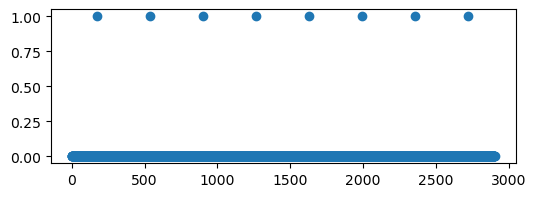

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize = (6,2))
plt.scatter(range(2904), fCoder.get_features(state,0))

#### Обучение агента

Теперь всё готово для обучения агента.

In [26]:
env = gym.make('MountainCar-v0')
n_episodes = 2000
env = gym.wrappers.RecordEpisodeStatistics(env, n_episodes)

agent = LinearModelAgent(env, fCoder)

# обучение агента и получение доходов по эпизодам
gains = SARSA_Nstep_control(env, agent, n_episodes = 2000, gamma=0.99,
                              eps_start=1.0, eps_decay = 0.993, eps_min = 0.001, 
                              alpha_start=0.05, alpha_decay = 0.993, alpha_min = 0.01, nstep=10)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:47<00:00, 42.37it/s]


In [32]:
import matplotlib.pyplot as plt
# для того, чтобы избежать ошибок при построении графиков
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# в названии графика среднее вознаграждение за 20 последних эпизодов
def plot_rewards(env_name, returns, label):
    fig = plt.figure(figsize=(16, 4))
    plt.title("Среда: "+env_name+", Средний доход за последние 20 эпизодов = "+str(np.mean(returns[-20:])))
    plt.plot(returns, label=label)
    plt.grid()
    plt.legend()
    plt.ylim(-500, 0)
    plt.show()

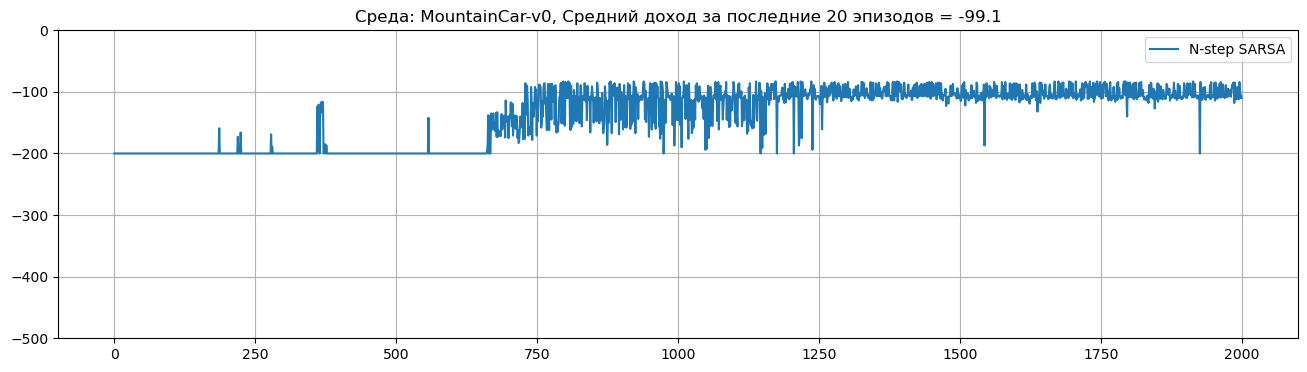

In [34]:
# график доходов
returns = np.array(env.return_queue)
plot_rewards('MountainCar-v0', returns, 'N-step SARSA')

Как видно из графика доходов, полученных в ходе обучения, уже к 500 эпизоду агент обучился хорошей стратегии.

In [40]:
np.max(agent.theta)

0.601732923716794

Ниже можно запустить 100 эпизодов симуляции работы обученного агента.

In [42]:
# создание экземпляра среды
env = gym.make('MountainCar-v0')
env = gym.wrappers.RecordEpisodeStatistics(env)

agent.play(env, 100)
print("Средний доход: ", np.mean(env.return_queue))
print("Минимальный доход: ", np.min(env.return_queue))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 89.61it/s]

Средний доход:  -102.13
Минимальный доход:  -116.0


In [48]:
# создание экземпляра среды
env = gym.make('MountainCar-v0', render_mode='human')
env = gym.wrappers.RecordEpisodeStatistics(env)

agent.play(env, 1)
print("Число шагов:", env.return_queue[-1])
env.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/it]

Число шагов: -104.0
